In [17]:
using DataFrames, Dates, Plots, CSV, DataFramesMeta, MLJ, StatsPlots, LaTeXStrings, DifferentialEquations
using Turing
using LazyArrays
using Random: seed!


In [2]:
function data_processing(country::String)
    data = CSV.read("C:/Users/olarinoyem/Documents/GitHub/covid-19-forcasting-experiments/data/confirmed_cases_global.csv", DataFrame)
    rename!(data, 1 => "province", 2 => "country")
    countries = collect(data[:, 2])
    row = findfirst(countries .== country)
    data_row = data[row, :]
    country_data = [i for i in values(data_row[5:end])]
    
    date_strings =String.(names(data))[5:end]
    format = Dates.DateFormat("m/d/Y")
    dates = parse.(Date, date_strings, format) + Year(2000)

    df = DataFrame(confirmed = country_data, dates = dates)    
    return df
end

data_processing (generic function with 1 method)

In [5]:
start_date = Date(2020,03,01);
end_date = Date(2020,12,01);

In [7]:
ng_data = data_processing("Nigeria");

# ng_filtered = @subset(ng_data, :confirmed .> 0)

Row,confirmed,dates
,Int64,Date
1,0,2020-01-22
2,0,2020-01-23
3,0,2020-01-24
4,0,2020-01-25
5,0,2020-01-26
6,0,2020-01-27
7,0,2020-01-28
8,0,2020-01-29
9,0,2020-01-30


In [8]:
# range_data = ng_filtered[2,start_date:end_date]

ng = filter(row -> start_date <= row.dates <= end_date, ng_data)

Row,confirmed,dates
,Int64,Date
1,1,2020-03-01
2,1,2020-03-02
3,1,2020-03-03
4,1,2020-03-04
5,1,2020-03-05
6,1,2020-03-06
7,1,2020-03-07
8,1,2020-03-08
9,2,2020-03-09


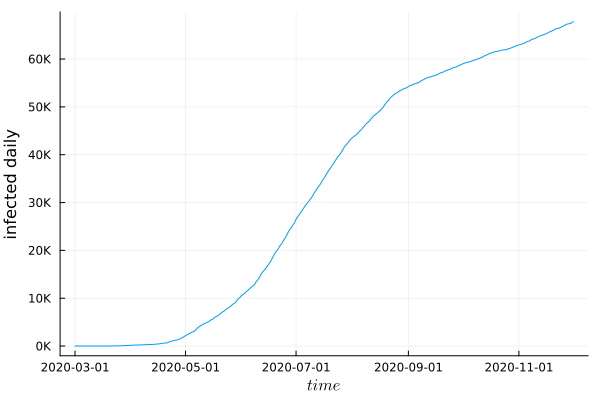

In [12]:
@df ng plot(:dates,
    :confirmed,
    xlab=L"time", ylab="infected daily",
    yformatter=y -> string(round(Int64, y ÷ 1_000)) * "K",
    label=false)

In [13]:
function sir_ode!(du, u, p, t)
    (S, I, R) = u
    (β, γ) = p
    N = S + I + R
    infection = β * I * S / N
    recovery = γ * I
    @inbounds begin
        du[1] = -infection # Susceptible
        du[2] = infection - recovery # Infected
        du[3] = recovery # Recovered
    end
    nothing
end;

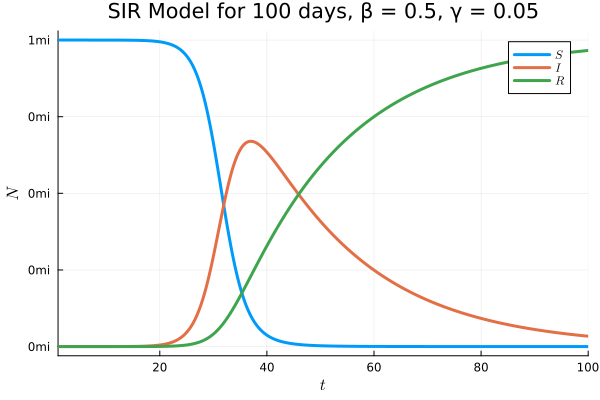

In [15]:
i₀ = first(ng[:, :confirmed])
N = 1000000

u = [N - i₀, i₀, 0.0]
p = [0.5, 0.05]
prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
sol_ode = solve(prob)
plot(sol_ode, label=[L"S" L"I" L"R"],
    lw=3,
    xlabel=L"t",
    ylabel=L"N",
    yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
    title="SIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

In [16]:
function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

NegativeBinomial2 (generic function with 1 method)

In [18]:
seed!(123)

@model function bayes_sir(infected, i₀, r₀, N)
    #calculate number of timepoints
    l = length(infected)

    #priors
    β ~ TruncatedNormal(2, 1, 1e-4, 10)     # using 10 because numerical issues arose
    γ ~ TruncatedNormal(0.4, 0.5, 1e-4, 10) # using 10 because numerical issues arose
    ϕ⁻ ~ truncated(Exponential(5); lower=0, upper=1e5)
    ϕ = 1.0 / ϕ⁻

    #ODE Stuff
    I = i₀
    u0 = [N - I, I, r₀] # S,I,R
    p = [β, γ]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_ode!,
        u0,
        tspan,
        p)
    sol = solve(prob,
        Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
        saveat=1.0)
    solᵢ = Array(sol)[2, :] # New Infected
    solᵢ = max.(1e-4, solᵢ) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(solᵢ, ϕ)))
end;

In [20]:
infected = ng[:, :confirmed]
r₀ = 0
model_sir = bayes_sir(infected, i₀, r₀, N)
chain_sir = sample(model_sir, NUTS(), 1_000)
summarystats(chain_sir[[:β, :γ]])

Sampling   0%|█                                         |  ETA: N/A
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\olarinoyem\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\olarinoyem\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\olarinoyem\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\olarinoyem\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\olarinoyem\.julia\packages\Turing\dl9my\src\inference\hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\olarinoyem\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


Sampling   0%|█                                         |  ETA: 2:35:11
Sampling   1%|█                                         |  ETA: 1:17:22


Sampling   1%|█                                         |  ETA: 0:51:24
Sampling   2%|█                                         |  ETA: 0:38:25
Sampling   2%|█                                         |  ETA: 0:30:37


Sampling   3%|██                                        |  ETA: 0:25:25


Sampling   3%|██                                        |  ETA: 0:21:46
Sampling   4%|██                                        |  ETA: 0:19:09


Sampling   4%|██                                        |  ETA: 0:17:03


Sampling   5%|██                                        |  ETA: 0:15:18


Sampling   5%|███                                       |  ETA: 0:14:05


Sampling   6%|███                                       |  ETA: 0:12:59


Sampling   6%|███                                       |  ETA: 0:11:56
Sampling   7%|███                                       |  ETA: 0:11:02


Sampling   7%|███                                       |  ETA: 0:10:15
Sampling   7%|████                                      |  ETA: 0:09:34
Sampling   8%|████                                      |  ETA: 0:08:58


Sampling   8%|████                                      |  ETA: 0:08:26
Sampling   9%|████                                      |  ETA: 0:07:57
Sampling   9%|████                                      |  ETA: 0:07:31


Sampling  10%|█████                                     |  ETA: 0:07:09
Sampling  10%|█████                                     |  ETA: 0:06:48
Sampling  11%|█████                                     |  ETA: 0:06:28


Sampling  11%|█████                                     |  ETA: 0:06:10
Sampling  12%|█████                                     |  ETA: 0:05:54
Sampling  12%|██████                                    |  ETA: 0:05:39


Sampling  13%|██████                                    |  ETA: 0:05:25
Sampling  13%|██████                                    |  ETA: 0:05:12


Sampling  14%|██████                                    |  ETA: 0:05:00


Sampling  14%|██████                                    |  ETA: 0:04:50
Sampling  14%|███████                                   |  ETA: 0:04:39


Sampling  15%|███████                                   |  ETA: 0:04:29
Sampling  15%|███████                                   |  ETA: 0:04:20


Sampling  16%|███████                                   |  ETA: 0:04:11
Sampling  16%|███████                                   |  ETA: 0:04:03


Sampling  17%|████████                                  |  ETA: 0:03:55


Sampling  17%|████████                                  |  ETA: 0:03:48
Sampling  18%|████████                                  |  ETA: 0:03:41
Sampling  18%|████████                                  |  ETA: 0:03:35


Sampling  19%|████████                                  |  ETA: 0:03:29
Sampling  19%|█████████                                 |  ETA: 0:03:23
Sampling  20%|█████████                                 |  ETA: 0:03:17


Sampling  20%|█████████                                 |  ETA: 0:03:11
Sampling  21%|█████████                                 |  ETA: 0:03:06
Sampling  21%|█████████                                 |  ETA: 0:03:01
Sampling  21%|██████████                                |  ETA: 0:02:56


Sampling  22%|██████████                                |  ETA: 0:02:51
Sampling  22%|██████████                                |  ETA: 0:02:47
Sampling  23%|██████████                                |  ETA: 0:02:42
Sampling  23%|██████████                                |  ETA: 0:02:38


Sampling  24%|██████████                                |  ETA: 0:02:35
Sampling  24%|███████████                               |  ETA: 0:02:31
Sampling  25%|███████████                               |  ETA: 0:02:27


Sampling  25%|███████████                               |  ETA: 0:02:24
Sampling  26%|███████████                               |  ETA: 0:02:20


Sampling  26%|███████████                               |  ETA: 0:02:17
Sampling  27%|████████████                              |  ETA: 0:02:14
Sampling  27%|████████████                              |  ETA: 0:02:11


Sampling  28%|████████████                              |  ETA: 0:02:08
Sampling  28%|████████████                              |  ETA: 0:02:05
Sampling  28%|████████████                              |  ETA: 0:02:02
Sampling  29%|█████████████                             |  ETA: 0:01:59
Sampling  29%|█████████████                             |  ETA: 0:01:57


Sampling  30%|█████████████                             |  ETA: 0:01:54
Sampling  30%|█████████████                             |  ETA: 0:01:52
Sampling  31%|█████████████                             |  ETA: 0:01:50
Sampling  31%|██████████████                            |  ETA: 0:01:47


Sampling  32%|██████████████                            |  ETA: 0:01:45
Sampling  32%|██████████████                            |  ETA: 0:01:43
Sampling  33%|██████████████                            |  ETA: 0:01:41
Sampling  33%|██████████████                            |  ETA: 0:01:39


Sampling  34%|███████████████                           |  ETA: 0:01:37
Sampling  34%|███████████████                           |  ETA: 0:01:35
Sampling  35%|███████████████                           |  ETA: 0:01:33
Sampling  35%|███████████████                           |  ETA: 0:01:31
Sampling  35%|███████████████                           |  ETA: 0:01:29
Sampling  36%|████████████████                          |  ETA: 0:01:27
Sampling  36%|████████████████                          |  ETA: 0:01:26
Sampling  37%|████████████████                          |  ETA: 0:01:24
Sampling  37%|████████████████                          |  ETA: 0:01:22


Sampling  38%|████████████████                          |  ETA: 0:01:21
Sampling  38%|█████████████████                         |  ETA: 0:01:19
Sampling  39%|█████████████████                         |  ETA: 0:01:18
Sampling  39%|█████████████████                         |  ETA: 0:01:16
Sampling  40%|█████████████████                         |  ETA: 0:01:15


Sampling  40%|█████████████████                         |  ETA: 0:01:13
Sampling  41%|██████████████████                        |  ETA: 0:01:12
Sampling  41%|██████████████████                        |  ETA: 0:01:11
Sampling  42%|██████████████████                        |  ETA: 0:01:09
Sampling  42%|██████████████████                        |  ETA: 0:01:08
Sampling  42%|██████████████████                        |  ETA: 0:01:07
Sampling  43%|███████████████████                       |  ETA: 0:01:05


Sampling  43%|███████████████████                       |  ETA: 0:01:04
Sampling  44%|███████████████████                       |  ETA: 0:01:03
Sampling  44%|███████████████████                       |  ETA: 0:01:02
Sampling  45%|███████████████████                       |  ETA: 0:01:01


Sampling  45%|████████████████████                      |  ETA: 0:01:00
Sampling  46%|████████████████████                      |  ETA: 0:00:59
Sampling  46%|████████████████████                      |  ETA: 0:00:58
Sampling  47%|████████████████████                      |  ETA: 0:00:56
Sampling  47%|████████████████████                      |  ETA: 0:00:55
Sampling  48%|████████████████████                      |  ETA: 0:00:54
Sampling  48%|█████████████████████                     |  ETA: 0:00:53


Sampling  49%|█████████████████████                     |  ETA: 0:00:52
Sampling  49%|█████████████████████                     |  ETA: 0:00:52
Sampling  49%|█████████████████████                     |  ETA: 0:00:51
Sampling  50%|█████████████████████                     |  ETA: 0:00:50
Sampling  50%|██████████████████████                    |  ETA: 0:00:49
Sampling  51%|██████████████████████                    |  ETA: 0:00:48


Sampling  51%|██████████████████████                    |  ETA: 0:00:47
Sampling  52%|██████████████████████                    |  ETA: 0:00:46
Sampling  52%|██████████████████████                    |  ETA: 0:00:45
Sampling  53%|███████████████████████                   |  ETA: 0:00:45


Sampling  53%|███████████████████████                   |  ETA: 0:00:44
Sampling  54%|███████████████████████                   |  ETA: 0:00:43
Sampling  54%|███████████████████████                   |  ETA: 0:00:42
Sampling  55%|███████████████████████                   |  ETA: 0:00:41
Sampling  55%|████████████████████████                  |  ETA: 0:00:41


Sampling  56%|████████████████████████                  |  ETA: 0:00:40
Sampling  56%|████████████████████████                  |  ETA: 0:00:39
Sampling  56%|████████████████████████                  |  ETA: 0:00:38
Sampling  57%|████████████████████████                  |  ETA: 0:00:38


Sampling  57%|█████████████████████████                 |  ETA: 0:00:37
Sampling  58%|█████████████████████████                 |  ETA: 0:00:36
Sampling  58%|█████████████████████████                 |  ETA: 0:00:36
Sampling  59%|█████████████████████████                 |  ETA: 0:00:35
Sampling  59%|█████████████████████████                 |  ETA: 0:00:34


Sampling  60%|██████████████████████████                |  ETA: 0:00:34
Sampling  60%|██████████████████████████                |  ETA: 0:00:33
Sampling  61%|██████████████████████████                |  ETA: 0:00:32


Sampling  61%|██████████████████████████                |  ETA: 0:00:32
Sampling  62%|██████████████████████████                |  ETA: 0:00:31
Sampling  62%|███████████████████████████               |  ETA: 0:00:31


Sampling  63%|███████████████████████████               |  ETA: 0:00:30
Sampling  63%|███████████████████████████               |  ETA: 0:00:30
Sampling  63%|███████████████████████████               |  ETA: 0:00:29
Sampling  64%|███████████████████████████               |  ETA: 0:00:28


Sampling  64%|████████████████████████████              |  ETA: 0:00:28
Sampling  65%|████████████████████████████              |  ETA: 0:00:27
Sampling  65%|████████████████████████████              |  ETA: 0:00:27
Sampling  66%|████████████████████████████              |  ETA: 0:00:26


Sampling  66%|████████████████████████████              |  ETA: 0:00:26
Sampling  67%|█████████████████████████████             |  ETA: 0:00:25
Sampling  67%|█████████████████████████████             |  ETA: 0:00:25
Sampling  68%|█████████████████████████████             |  ETA: 0:00:24


Sampling  68%|█████████████████████████████             |  ETA: 0:00:24
Sampling  69%|█████████████████████████████             |  ETA: 0:00:23
Sampling  69%|██████████████████████████████            |  ETA: 0:00:23
Sampling  70%|██████████████████████████████            |  ETA: 0:00:22
Sampling  70%|██████████████████████████████            |  ETA: 0:00:22


Sampling  70%|██████████████████████████████            |  ETA: 0:00:21
Sampling  71%|██████████████████████████████            |  ETA: 0:00:21
Sampling  71%|██████████████████████████████            |  ETA: 0:00:20
Sampling  72%|███████████████████████████████           |  ETA: 0:00:20


Sampling  72%|███████████████████████████████           |  ETA: 0:00:19
Sampling  73%|███████████████████████████████           |  ETA: 0:00:19
Sampling  73%|███████████████████████████████           |  ETA: 0:00:19
Sampling  74%|███████████████████████████████           |  ETA: 0:00:18
Sampling  74%|████████████████████████████████          |  ETA: 0:00:18


Sampling  75%|████████████████████████████████          |  ETA: 0:00:17
Sampling  75%|████████████████████████████████          |  ETA: 0:00:17
Sampling  76%|████████████████████████████████          |  ETA: 0:00:16
Sampling  76%|████████████████████████████████          |  ETA: 0:00:16


Sampling  77%|█████████████████████████████████         |  ETA: 0:00:16
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:15


Sampling  77%|█████████████████████████████████         |  ETA: 0:00:15
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:14
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:14


Sampling  79%|██████████████████████████████████        |  ETA: 0:00:14
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:13
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:13
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:13
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:12


Sampling  81%|███████████████████████████████████       |  ETA: 0:00:12
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:12
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:11
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:11


Sampling  83%|███████████████████████████████████       |  ETA: 0:00:10
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:10
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:10
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:09
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:09


Sampling  85%|████████████████████████████████████      |  ETA: 0:00:09
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:08
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:08


Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:08
Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:08
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:07
Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:07
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:07


Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:06
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:06
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:06
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:05
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:05
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:05
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:05


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:04
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:04
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:04
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:03


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:03
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:03
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:03
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:02


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:02


Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:02
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:02
Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:01


Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:01
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:01
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:01
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:53


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           β    0.1440    0.0023     0.0001    0.0001   1368.0912    1.0002    ⋯
           γ    0.0240    0.0010     0.0000    0.0000   1429.8568    0.9990    ⋯
                                                                1 column omitted


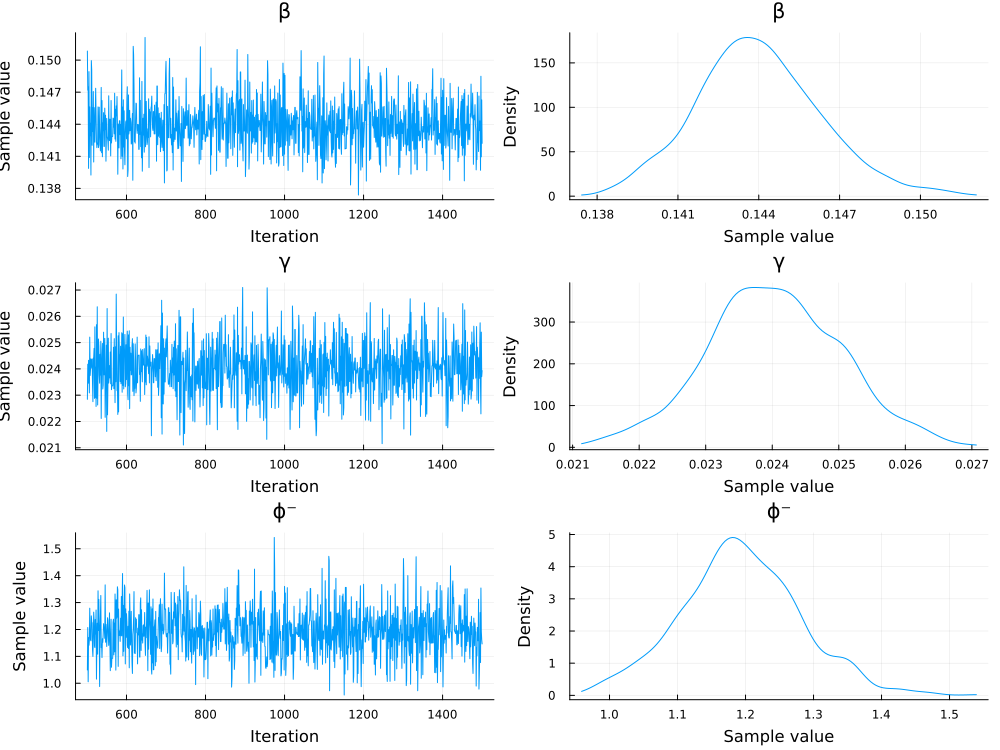

In [21]:
plot(chain_sir)